In [ ]:
# Diagnose errors with the GPU

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset
from huggingface_hub import login
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

DATASET_ID = "ADS509/full_experiment_labels"

MODELS = {
    "RoBERTa": "ADS509/experiment_labels_roberta_base",
    "BERTweet": "ADS509/BERTweet-large-self-labeling",
    "BERT base": "ADS509/experiment_labels_bert_base",
}

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
GPU available: True
GPU: NVIDIA A100-SXM4-40GB


In [3]:
# Hugging Face login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


# Load Test Data

In [5]:
dataset = load_dataset(DATASET_ID)

test_split = dataset["test"]
texts = list(test_split["text"])
true_preds = np.array(test_split["label"])

print(f"\nTest samples : {len(texts):,}")
unique, counts = np.unique(true_preds, return_counts=True)
print(f"Label distribution:")
for lbl, cnt in zip(unique, counts):
    print(f"  {lbl}: {cnt:,}")


Test samples : 10,558
Label distribution:
  0: 779
  1: 3,257
  2: 2,423
  3: 3,289
  4: 810


## Load Pipeline

Uses `transformers.pipeline()` which handles tokenization, batching, and inference internally.
Simplest approach — good for quick evaluation and deployment.

In [ ]:
def predict_pipeline(model_id: str, texts: list, k: int=3, max_length: int=512, device: int = 0, batch_size: int = 32) -> tuple:
    """
    Run text-classification predictions using a HuggingFace pipeline.

    Returns:
        pred_ints  : list of integer class predictions aligned with dataset label IDs
        id2label   : dict mapping integer IDs -> label name strings
    """
    pipe = pipeline(
        "text-classification",
        model=model_id,
        device=device,
        truncation=True,
        padding=True,
        max_length=max_length,
        batch_size=batch_size,
    )
    id2label = pipe.model.config.id2label

    predictions = pipe(texts, top_k=k)
    return predictions, id2label

### Experiment Labels Evaluation

In [ ]:
preds, id2label = predict_pipeline(model_id="ADS509/BERTweet-large-self-labeling", texts=texts)

# Convert the integer labels into named labels for readability
true_labels = [id2label[i] for i in true_preds]

# If using top_k, this will get the top prediction label and score, otherwise remove the index slicing
top_preds = [pred[0]['label'] for pred in preds]
top_scores = [pred[0]['score'] for pred in preds]

# Get the label and scores of the next predictions.  Comment out the below if not using top_k or using top_k < 3
top2_pred = [f"{pred[1]['label']}: {pred[1]['score']}" for pred in preds]
top3_pred = [f"{pred[2]['label']}: {pred[2]['score']}" for pred in preds]

print(classification_report(true_labels, top_preds))

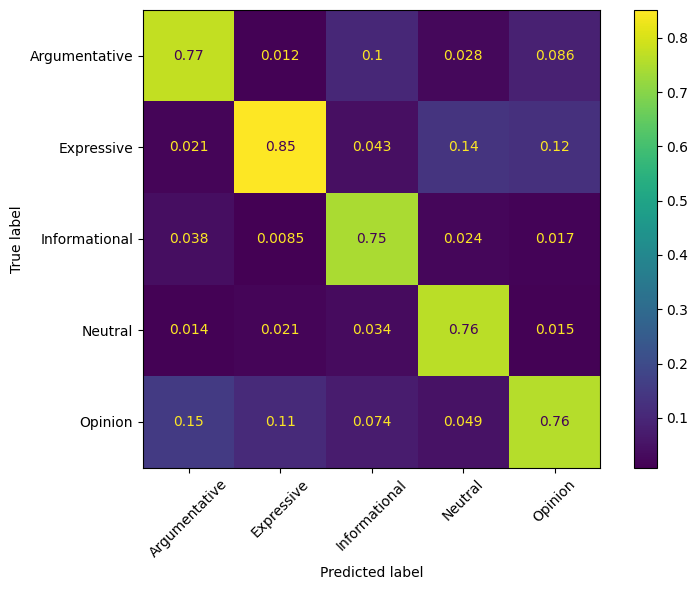

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    true_labels, top_preds, 
    xticks_rotation=45,
    normalize='pred',
    ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
confidence_threshold = 0.6
df = test_split.to_pandas()

# Create column with top prediction and score, and convert true label integers to named labels
df['preds'] = top_preds
df['top_score'] = top_scores
df['label'] = df['label'].apply(lambda x: id2label[x])

# Get the predictions made with low confidence
df['low_conf'] = df['top_score'].apply(lambda x: True if x < confidence_threshold else False)

# Mark the next most likely prediction, comment out if not using top_k
df['second_place'] = top2_pred
df['third_place'] = top3_pred

# Create low confidence and overconfident subsets
low_conf = df[df['low_conf'] == True]
over_conf = df[(df['top_score'] > 0.90) & (df["preds"] != df['label'])]

In [ ]:
# Explore unconfident predictions
idx = 7

print("True label: ", low_conf['label'].iloc[idx])
print("Predicted label: ", low_conf['preds'].iloc[idx])
print("Predicted score: ", low_conf['top_score'].iloc[idx], "\n")
print("2nd Predicted label: ", low_conf['second_place'].iloc[idx], "\n")
print("Text:\n\n", low_conf['text'].iloc[idx])

True label:  Informational
Predicted label:  Opinion
Predicted score:  0.5329594016075134 

2nd Predicted label:  Informational: 0.43163278698921204 

Text:

 there's no alqaeda in palestine


In [33]:
# Explore overconfident predictions
idx = 7

print("True label: ", over_conf['label'].iloc[idx])
print("Predicted label: ", over_conf['preds'].iloc[idx])
print("Predicted score: ", over_conf['top_score'].iloc[idx], "\n")
print("2nd Predicted label: ", over_conf['second_place'].iloc[idx], "\n")
print("Text:\n\n", over_conf['text'].iloc[idx])

True label:  Opinion
Predicted label:  Argumentative
Predicted score:  0.910280704498291 

2nd Predicted label:  Opinion: 0.08203508704900742 

Text:

 ai exists to: 1) make insanely rich oligarchs and their obsequies sycophants even more money; 2) fire as many people as possible; and 3) ramp up the above oligarchs control of our people (regular people) more and more and more. a real regular peoples party would kill it with fire, fire stated with palatir stock


### Source Evaluation